# Custom material model
In this demo we show how you can use pulse together with a custom material model. To illustrate this we will implement a model for a Mooney-Rivelin material.

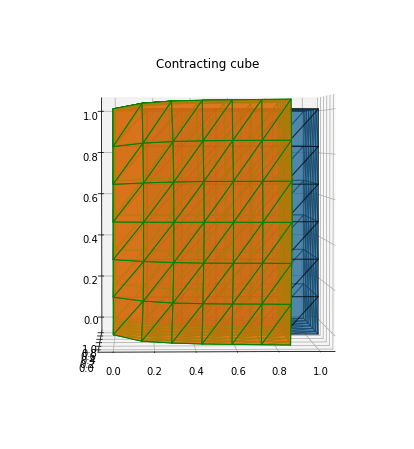

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import dolfin

import pulse
plt.rcParams["figure.figsize"] = (10,8)

# Create mesh
N = 6
mesh = dolfin.UnitCubeMesh(N, N, N)


# Create subdomains
class Free(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > (1.0 - dolfin.DOLFIN_EPS) and on_boundary


class Fixed(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        return x[0] < dolfin.DOLFIN_EPS and on_boundary


# Create a facet fuction in order to mark the subdomains
ffun = dolfin.MeshFunction("size_t", mesh, 2)
ffun.set_all(0)

# Mark the first subdomain with value 1
fixed = Fixed()
fixed_marker = 1
fixed.mark(ffun, fixed_marker)

# Mark the second subdomain with value 2
free = Free()
free_marker = 2
free.mark(ffun, free_marker)

# Create a cell function (but we are not using it)
cfun = dolfin.MeshFunction("size_t", mesh, 3)
cfun.set_all(0)


# Collect the functions containing the markers
marker_functions = pulse.MarkerFunctions(ffun=ffun, cfun=cfun)

# Collect the individual markers
fixed_marker = pulse.Marker(name='fixed', value=1, dimension=2)
free_marker = pulse.Marker(name='free', value=2, dimension=2)
markers = (fixed_marker, free_marker)

# Create mictrotructure
f0 = dolfin.Expression(("1.0", "0.0", "0.0"), degree=1, cell=mesh.ufl_cell())
s0 = dolfin.Expression(("0.0", "1.0", "0.0"), degree=1, cell=mesh.ufl_cell())
n0 = dolfin.Expression(("0.0", "0.0", "1.0"), degree=1, cell=mesh.ufl_cell())

# Collect the mictrotructure
microstructure = pulse.Microstructure(f0=f0, s0=s0, n0=n0)

# Create the geometry
geometry = pulse.Geometry(mesh=mesh, markers=markers,
                          marker_functions=marker_functions,
                          microstructure=microstructure)


# Use the default material parameters
class MooneyRivelin(pulse.Material):

    @staticmethod
    def default_parameters():
        return dict(C1=1.0, C2=1.0)

    def strain_energy(self, F_):

        # Get elastic part of deformation gradient,
        # in case of active strain model
        F = self.active.Fe(F_)

        # Active stress (which is zero for acitve strain)
        Wactive = self.active.Wactive(F, diff=0)

        I1 = self.active.I1(F)
        I2 = self.active.I2(F)

        return self.C1 * (I1 - 3) + self.C2 * (I2 - 3) + Wactive


# Select model for active contraction
active_model = "active_strain"
# active_model = "active_stress"

# Set the activation
activation = dolfin.Constant(0.1)

# Create material
material = MooneyRivelin(active_model=active_model,
                         activation=activation)


# Make Dirichlet boundary conditions
def dirichlet_bc(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    return dolfin.DirichletBC(V,
                              dolfin.Constant((0.0, 0.0, 0.0)),
                              fixed)


# Make Neumann boundary conditions
neumann_bc = pulse.NeumannBC(traction=dolfin.Constant(0.0),
                             marker=free_marker.value)

# Collect Boundary Conditions
bcs = pulse.BoundaryConditions(dirichlet=(dirichlet_bc,),
                               neumann=(neumann_bc,))

# Create problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

# Solve problem
problem.solve()

# Get displacement and hydrostatic pressure
u, p = problem.state.split(deepcopy=True)

# Plot
u_int = dolfin.interpolate(u,
                           dolfin.VectorFunctionSpace(geometry.mesh, "CG", 1))
mesh = dolfin.Mesh(geometry.mesh)
dolfin.ALE.move(mesh, u_int)
dolfin.plot(geometry.mesh, alpha=0.5, edgecolor='k', title="original")
dolfin.plot(mesh, edgecolor='g', alpha=0.7, title='Contracting cube')
ax = plt.gca()
ax.view_init(elev=2, azim=-92)
plt.show()